In [2]:
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.preprocessing import LabelEncoder
from scipy.stats import friedmanchisquare
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report


In [45]:
## Load Data
base_path = 'homeworks/data/project/gesture_phase/'
df = pd.read_csv(base_path + 'gesture_phase.csv')

In [5]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,Phase
0,-0.000010,-0.000021,0.000005,-0.000006,0.000043,-0.000011,0.000004,-0.000027,0.000006,-0.000029,...,-1.770000e-06,0.000024,0.000045,0.000028,0.000084,0.000003,0.000010,0.000004,0.000015,D
1,-0.000006,-0.000017,0.000004,-0.000020,0.000064,-0.000010,0.000008,-0.000023,0.000005,-0.000045,...,-1.770000e-06,0.000019,0.000068,0.000025,0.000154,0.000002,0.000008,0.000002,0.000021,D
2,-0.000025,-0.000026,0.000004,-0.000027,0.000061,-0.000008,-0.000005,-0.000030,0.000007,-0.000053,...,9.100000e-07,0.000036,0.000067,0.000031,0.000154,0.000006,0.000003,0.000005,0.000003,D
3,-0.000041,-0.000037,0.000005,-0.000033,0.000060,-0.000006,-0.000020,-0.000038,0.000009,-0.000051,...,1.660000e-06,0.000055,0.000069,0.000044,0.000127,0.000006,0.000002,0.000005,0.000008,D
4,-0.000052,-0.000046,0.000005,-0.000030,0.000044,-0.000004,-0.000029,-0.000045,0.000010,-0.000039,...,2.100000e-06,0.000069,0.000054,0.000054,0.000068,0.000004,0.000005,0.000003,0.000018,D


In [6]:
## df values to numpy array
X = df.values[:, :-1]
y_target = df.values[:, -1]
labels = np.unique(y_target)
le = LabelEncoder()
y = le.fit_transform(y_target)

## Split data

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


In [8]:
## Define the search space for the hyperparameter tuning with hyperopt
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 4000, 1),
    'eta': hp.loguniform('eta', np.log(1e-7), np.log(1)),  # Usando np.log para el rango
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.2, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.2, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.2, 1),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1e-16), np.log(1e5)),
    'alpha': hp.choice('alpha', [0, hp.loguniform('alpha_loguniform', np.log(1e-16), np.log(1e2))]),
    'lambda': hp.choice('lambda', [0, hp.loguniform('lambda_loguniform', np.log(1e-16), np.log(1e2))]),
    'gamma': hp.choice('gamma', [0, hp.loguniform('gamma_loguniform', np.log(1e-16), np.log(1e2))])
}

def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    model = xgb.XGBClassifier(**params, objective='multi:softprob')  # Ajusta el objetivo según tu problema
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)
    y_prob = model.predict_proba(X_test)
    loss = log_loss(y_test, y_prob)
   
    return {'loss': loss, 'status': STATUS_OK}
    

# Optimización
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

[0]	validation_0-mlogloss:1.56728                     
[1]	validation_0-mlogloss:1.53387                     
[2]	validation_0-mlogloss:1.50513                     
[3]	validation_0-mlogloss:1.48050                     
[4]	validation_0-mlogloss:1.45634                     
[5]	validation_0-mlogloss:1.43326                     
[6]	validation_0-mlogloss:1.41140                     
[7]	validation_0-mlogloss:1.39394                     
[8]	validation_0-mlogloss:1.37670                     
[9]	validation_0-mlogloss:1.36222                     
[10]	validation_0-mlogloss:1.34957                    
[11]	validation_0-mlogloss:1.33797                    
[12]	validation_0-mlogloss:1.32649                    
[13]	validation_0-mlogloss:1.31624                    
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[14]	validation_0-mlogloss:1.30740                    
[15]	validation_0-mlogloss:1.29851                    
[16]	validation_0-mlogloss:1.29138                    
[17]	validation_0-mlogloss:1.28427                    
[18]	validation_0-mlogloss:1.27680                    
[19]	validation_0-mlogloss:1.27098                    
[20]	validation_0-mlogloss:1.26509                    
[21]	validation_0-mlogloss:1.25881                    
[22]	validation_0-mlogloss:1.25362                    
[23]	validation_0-mlogloss:1.24936                    
[24]	validation_0-mlogloss:1.24423                    
[25]	validation_0-mlogloss:1.23910                    
[26]	validation_0-mlogloss:1.23492                    
[27]	validation_0-mlogloss:1.23062                    
[28]	validation_0-mlogloss:1.22714                    
[29]	validation_0-mlogloss:1.22397                    
[30]	validation_0-mlogloss:1.22076                    
[31]	validation_0-mlogloss:1.21816                    
[32]	valid

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[7]	validation_0-mlogloss:1.60942                                               
[8]	validation_0-mlogloss:1.60941                                               
[9]	validation_0-mlogloss:1.60941                                               
[10]	validation_0-mlogloss:1.60941                                              
[11]	validation_0-mlogloss:1.60941                                              
[12]	validation_0-mlogloss:1.60940                                              
[13]	validation_0-mlogloss:1.60940                                              
[14]	validation_0-mlogloss:1.60940                                              
[15]	validation_0-mlogloss:1.60940                                              
[16]	validation_0-mlogloss:1.60939                                              
[17]	validation_0-mlogloss:1.60939                                              
[18]	validation_0-mlogloss:1.60939                                              
[19]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-mlogloss:1.56924                                               
[1]	validation_0-mlogloss:1.53342                                               
[2]	validation_0-mlogloss:1.50419                                               
[3]	validation_0-mlogloss:1.47283                                               
[4]	validation_0-mlogloss:1.44601                                               
[5]	validation_0-mlogloss:1.41936                                               
[6]	validation_0-mlogloss:1.39742                                               
[7]	validation_0-mlogloss:1.37713                                               
[8]	validation_0-mlogloss:1.35873                                               
[9]	validation_0-mlogloss:1.33904                                               
[10]	validation_0-mlogloss:1.32079                                              
[11]	validation_0-mlogloss:1.30508                                              
[12]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[7]	validation_0-mlogloss:1.60797                                              
[8]	validation_0-mlogloss:1.60779                                              
[9]	validation_0-mlogloss:1.60761                                              
[10]	validation_0-mlogloss:1.60742                                             
[11]	validation_0-mlogloss:1.60723                                             
[12]	validation_0-mlogloss:1.60704                                             
[13]	validation_0-mlogloss:1.60685                                             
[14]	validation_0-mlogloss:1.60666                                             
[15]	validation_0-mlogloss:1.60649                                             
[16]	validation_0-mlogloss:1.60630                                             
[17]	validation_0-mlogloss:1.60610                                             
[18]	validation_0-mlogloss:1.60592                                             
[19]	validation_0-mlogloss:1.60573      

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[3]	validation_0-mlogloss:1.58472                                              
[4]	validation_0-mlogloss:1.57879                                              
[5]	validation_0-mlogloss:1.57272                                              
[6]	validation_0-mlogloss:1.56662                                              
[7]	validation_0-mlogloss:1.56133                                              
[8]	validation_0-mlogloss:1.55587                                              
[9]	validation_0-mlogloss:1.55051                                              
[10]	validation_0-mlogloss:1.54508                                             
[11]	validation_0-mlogloss:1.53978                                             
[12]	validation_0-mlogloss:1.53439                                             
[13]	validation_0-mlogloss:1.52886                                             
[14]	validation_0-mlogloss:1.52334                                             
[15]	validation_0-mlogloss:1.51857      

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[7]	validation_0-mlogloss:1.60943                                               
[8]	validation_0-mlogloss:1.60942                                               
[9]	validation_0-mlogloss:1.60942                                               
[10]	validation_0-mlogloss:1.60942                                              
[11]	validation_0-mlogloss:1.60942                                              
[12]	validation_0-mlogloss:1.60942                                              
[13]	validation_0-mlogloss:1.60942                                              
[14]	validation_0-mlogloss:1.60941                                              
[15]	validation_0-mlogloss:1.60941                                              
[16]	validation_0-mlogloss:1.60941                                              
[17]	validation_0-mlogloss:1.60941                                              
[18]	validation_0-mlogloss:1.60941                                              
[19]	validation_0-mlogloss:1

In [10]:
print(best)

{'alpha': 0, 'colsample_bylevel': 0.8249151342265375, 'colsample_bytree': 0.8636398295947607, 'eta': 0.009034924637787108, 'gamma': 0, 'lambda': 1, 'lambda_loguniform': 3.121276402279249e-14, 'max_depth': 8.0, 'min_child_weight': 0.04458882005745857, 'n_estimators': 3888.0, 'subsample': 0.9875487142962278}


In [11]:
# Entrenar el modelo final con los mejores parámetros
best_params = space.copy()
best_params
for param, val in best.items():
    if param == 'max_depth' or param == 'n_estimators':
        best_params[param] = int(val)  # Convertir max_depth a int
    else:
        best_params[param] = val
best_model = xgb.XGBClassifier(**best_params, objective='multi:softprob')
best_model.fit(X_train, y_train)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:45:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "lambda_loguniform" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8249151342265375, colsample_bynode=None,
              colsample_bytree=0.8636398295947607, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.009034924637787108, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1,
              lambda_loguniform=3.121276402279249e-14, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=0.04458882005745857, missing=nan,
              monotone_constraints=None, multi_strategy=None, ...)

In [12]:
best_model.save_model(base_path + 'best_model.json')


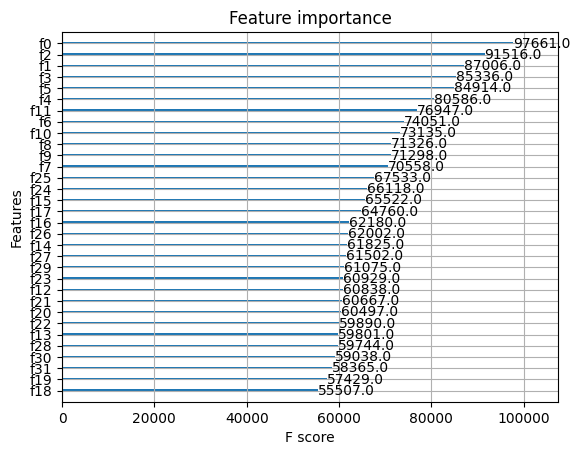

In [46]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Load the model
model = xgb.Booster()
model.load_model(base_path + 'best_model.json')

# Plot feature importance
plot_importance(model)
plt.show()

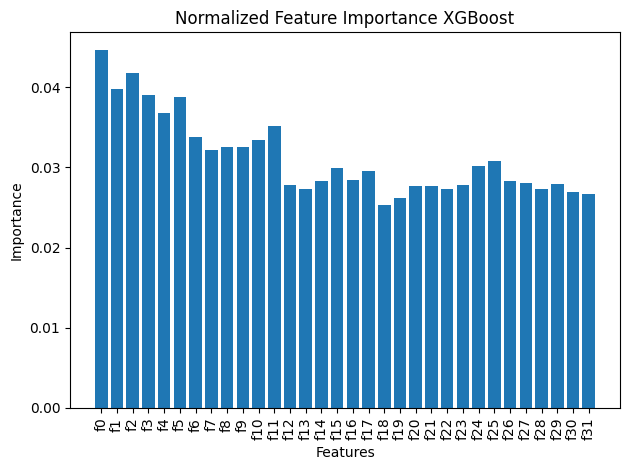

In [52]:
# Get feature importance
f_importance = model.get_score(importance_type='weight')

# Normalize feature importance
norm_f_importance = {k: v / sum(f_importance.values()) for k, v in f_importance.items()}

# Plot normalized feature importance
plt.bar(range(len(norm_f_importance)), list(norm_f_importance.values()), align='center')
plt.xticks(range(len(norm_f_importance)), list(norm_f_importance.keys()),rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Normalized Feature Importance XGBoost')
plt.tight_layout()
plt.savefig(base_path + 'feature_importance_xgboost.png')
plt.show()

In [13]:
best_model.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': 0.8249151342265375,
 'colsample_bynode': None,
 'colsample_bytree': 0.8636398295947607,
 'device': None,
 'eval_metric': None,
 'gamma': 0,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 8,
 'max_leaves': None,
 'min_child_weight': 0.04458882005745857,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9875487142962278,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.009034924637787108,
 'alpha': 0,
 'lambda': 1,
 'lambda_loguniform': 3.121276402279249e-14}

In [14]:
## evaluate the model
y_pred = best_model.predict(X_test)
print(trials.best_trial['result'])

{'loss': 0.8828717908990212, 'status': 'ok'}


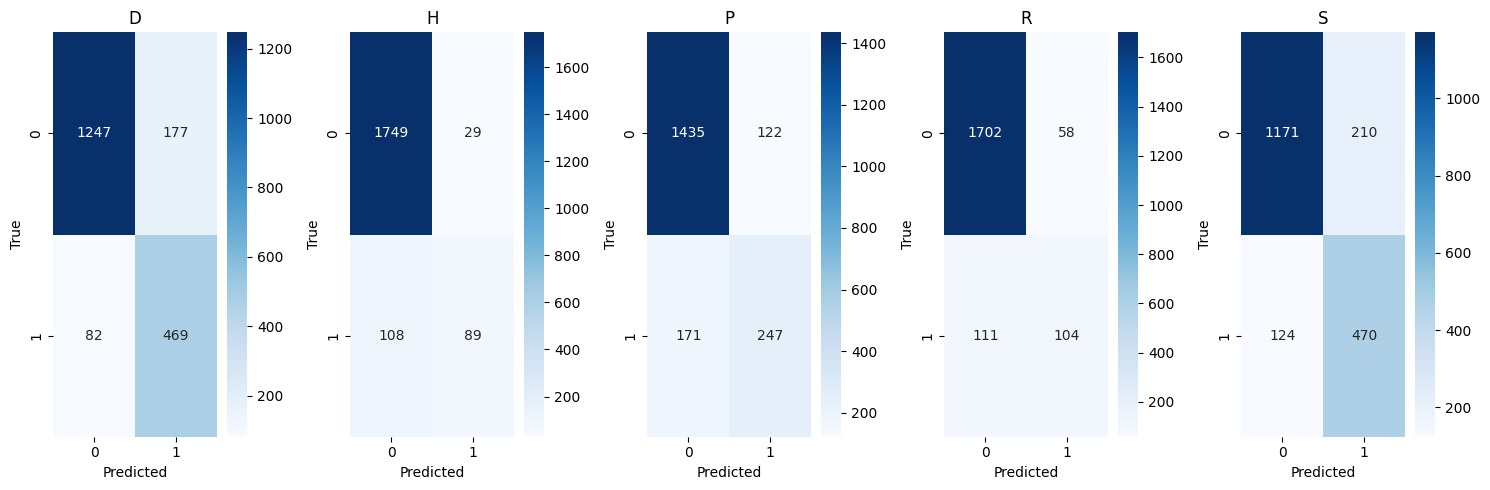

In [15]:
## confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_test, y_pred)

# Crear una figura y un conjunto de subtramas
fig, ax = plt.subplots(nrows=1, ncols=mcm.shape[0], figsize=(15, 5))

# Dibujar un mapa de calor para cada matriz de confusión
for axes, cm, label in zip(ax.flatten(), mcm, labels):
    sns.heatmap(cm, annot=True, fmt='d', ax=axes, cmap='Blues')
    axes.set_xlabel('Predicted')
    axes.set_ylabel('True')
    axes.set_title(label)

plt.tight_layout()
plt.savefig(base_path + 'confusion_matrix.png')
plt.show()

In [17]:
report = classification_report(y_test, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

           D       0.73      0.85      0.78       551
           H       0.75      0.45      0.57       197
           P       0.67      0.59      0.63       418
           R       0.64      0.48      0.55       215
           S       0.69      0.79      0.74       594

    accuracy                           0.70      1975
   macro avg       0.70      0.63      0.65      1975
weighted avg       0.70      0.70      0.69      1975



## Experiment with Shrutime (Two Class)



In [18]:
base_path = 'homeworks/data/project/'
df_shruntime = pd.read_csv(base_path + 'shrutime_encoded.csv')

X = df.values[:, :-1]
y_target = df.values[:, -1]

## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


In [21]:
## Optimization hyperparameters
def objectiveBinary(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    model = xgb.XGBClassifier(**params, objective='binary:logistic')  # 
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)
    y_prob = model.predict_proba(X_test)
    loss = log_loss(y_test, y_prob)
    
    return {'loss': loss, 'status': STATUS_OK}
trials = Trials()
best = fmin(objectiveBinary, space, algo=tpe.suggest, max_evals=10, trials=trials, verbose=0)


[0]	validation_0-mlogloss:1.56206
[1]	validation_0-mlogloss:1.53413
[2]	validation_0-mlogloss:1.50640
[3]	validation_0-mlogloss:1.48048
[4]	validation_0-mlogloss:1.45734
[5]	validation_0-mlogloss:1.43716
[6]	validation_0-mlogloss:1.41732
[7]	validation_0-mlogloss:1.39820
[8]	validation_0-mlogloss:1.38133
[9]	validation_0-mlogloss:1.36745
[10]	validation_0-mlogloss:1.35707
[11]	validation_0-mlogloss:1.34469
[12]	validation_0-mlogloss:1.33580
[13]	validation_0-mlogloss:1.32838
[14]	validation_0-mlogloss:1.32112
[15]	validation_0-mlogloss:1.31296
[16]	validation_0-mlogloss:1.30593
[17]	validation_0-mlogloss:1.29956
[18]	validation_0-mlogloss:1.29489
[19]	validation_0-mlogloss:1.28827


[20]	validation_0-mlogloss:1.28311
[21]	validation_0-mlogloss:1.27778
[22]	validation_0-mlogloss:1.27371
[23]	validation_0-mlogloss:1.27159
[24]	validation_0-mlogloss:1.26572
[25]	validation_0-mlogloss:1.26248
[26]	validation_0-mlogloss:1.25970
[27]	validation_0-mlogloss:1.25753
[28]	validation_0-mlogloss:1.25496
[29]	validation_0-mlogloss:1.25321
[30]	validation_0-mlogloss:1.25024
[31]	validation_0-mlogloss:1.24724
[32]	validation_0-mlogloss:1.24375
[33]	validation_0-mlogloss:1.24126
[34]	validation_0-mlogloss:1.24001
[35]	validation_0-mlogloss:1.23762
[36]	validation_0-mlogloss:1.23618
[37]	validation_0-mlogloss:1.23359
[38]	validation_0-mlogloss:1.23117
[39]	validation_0-mlogloss:1.22960
[40]	validation_0-mlogloss:1.22744
[41]	validation_0-mlogloss:1.22487
[42]	validation_0-mlogloss:1.22294
[43]	validation_0-mlogloss:1.22104
[44]	validation_0-mlogloss:1.21935
[45]	validation_0-mlogloss:1.21784
[46]	validation_0-mlogloss:1.21702
[47]	validation_0-mlogloss:1.21567
[48]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[49]	validation_0-mlogloss:1.21461
[50]	validation_0-mlogloss:1.21202
[51]	validation_0-mlogloss:1.21054
[52]	validation_0-mlogloss:1.20916
[53]	validation_0-mlogloss:1.20698
[54]	validation_0-mlogloss:1.20573
[55]	validation_0-mlogloss:1.20466
[56]	validation_0-mlogloss:1.20379
[57]	validation_0-mlogloss:1.20290
[58]	validation_0-mlogloss:1.20213
[59]	validation_0-mlogloss:1.20051
[60]	validation_0-mlogloss:1.19990
[61]	validation_0-mlogloss:1.19871
[62]	validation_0-mlogloss:1.19834
[63]	validation_0-mlogloss:1.19620
[64]	validation_0-mlogloss:1.19398
[65]	validation_0-mlogloss:1.19241
[66]	validation_0-mlogloss:1.19164
[67]	validation_0-mlogloss:1.19127
[68]	validation_0-mlogloss:1.18979
[69]	validation_0-mlogloss:1.18886
[70]	validation_0-mlogloss:1.18862
[71]	validation_0-mlogloss:1.18839
[72]	validation_0-mlogloss:1.18734
[73]	validation_0-mlogloss:1.18706
[74]	validation_0-mlogloss:1.18604
[75]	validation_0-mlogloss:1.18644
[76]	validation_0-mlogloss:1.18499
[77]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:1.60015
[2]	validation_0-mlogloss:1.59603
[3]	validation_0-mlogloss:1.59228
[4]	validation_0-mlogloss:1.58822
[5]	validation_0-mlogloss:1.58427
[6]	validation_0-mlogloss:1.58052
[7]	validation_0-mlogloss:1.57682
[8]	validation_0-mlogloss:1.57284
[9]	validation_0-mlogloss:1.56897
[10]	validation_0-mlogloss:1.56458
[11]	validation_0-mlogloss:1.56107
[12]	validation_0-mlogloss:1.55737
[13]	validation_0-mlogloss:1.55337
[14]	validation_0-mlogloss:1.54953
[15]	validation_0-mlogloss:1.54602
[16]	validation_0-mlogloss:1.54259
[17]	validation_0-mlogloss:1.53900
[18]	validation_0-mlogloss:1.53532
[19]	validation_0-mlogloss:1.53208
[20]	validation_0-mlogloss:1.52886
[21]	validation_0-mlogloss:1.52572
[22]	validation_0-mlogloss:1.52257
[23]	validation_0-mlogloss:1.51929
[24]	validation_0-mlogloss:1.51628
[25]	validation_0-mlogloss:1.51290
[26]	validation_0-mlogloss:1.51032
[27]	validation_0-mlogloss:1.50699
[28]	validation_0-mlogloss:1.50420
[29]	validation_0-mlogloss:1.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-mlogloss:1.60944
[5]	validation_0-mlogloss:1.60944
[6]	validation_0-mlogloss:1.60944
[7]	validation_0-mlogloss:1.60944
[8]	validation_0-mlogloss:1.60944
[9]	validation_0-mlogloss:1.60944
[10]	validation_0-mlogloss:1.60944
[11]	validation_0-mlogloss:1.60944
[12]	validation_0-mlogloss:1.60944
[13]	validation_0-mlogloss:1.60944
[14]	validation_0-mlogloss:1.60944
[15]	validation_0-mlogloss:1.60944
[16]	validation_0-mlogloss:1.60944
[17]	validation_0-mlogloss:1.60944
[18]	validation_0-mlogloss:1.60944
[19]	validation_0-mlogloss:1.60944
[20]	validation_0-mlogloss:1.60944
[21]	validation_0-mlogloss:1.60944
[22]	validation_0-mlogloss:1.60944
[23]	validation_0-mlogloss:1.60944
[24]	validation_0-mlogloss:1.60944
[25]	validation_0-mlogloss:1.60944
[26]	validation_0-mlogloss:1.60944
[27]	validation_0-mlogloss:1.60944
[28]	validation_0-mlogloss:1.60944
[29]	validation_0-mlogloss:1.60944
[30]	validation_0-mlogloss:1.60944
[31]	validation_0-mlogloss:1.60944
[32]	validation_0-mlogloss

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[40]	validation_0-mlogloss:1.53755
[41]	validation_0-mlogloss:1.53608
[42]	validation_0-mlogloss:1.53460
[43]	validation_0-mlogloss:1.53305
[44]	validation_0-mlogloss:1.53154
[45]	validation_0-mlogloss:1.52990
[46]	validation_0-mlogloss:1.52838
[47]	validation_0-mlogloss:1.52688
[48]	validation_0-mlogloss:1.52536
[49]	validation_0-mlogloss:1.52401
[50]	validation_0-mlogloss:1.52257
[51]	validation_0-mlogloss:1.52131
[52]	validation_0-mlogloss:1.51988
[53]	validation_0-mlogloss:1.51835
[54]	validation_0-mlogloss:1.51680
[55]	validation_0-mlogloss:1.51551
[56]	validation_0-mlogloss:1.51411
[57]	validation_0-mlogloss:1.51263
[58]	validation_0-mlogloss:1.51114
[59]	validation_0-mlogloss:1.50958
[60]	validation_0-mlogloss:1.50832
[61]	validation_0-mlogloss:1.50693
[62]	validation_0-mlogloss:1.50558
[63]	validation_0-mlogloss:1.50415
[64]	validation_0-mlogloss:1.50280
[65]	validation_0-mlogloss:1.50152
[66]	validation_0-mlogloss:1.50032
[67]	validation_0-mlogloss:1.49913
[68]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-mlogloss:1.26574
[40]	validation_0-mlogloss:1.26568
[41]	validation_0-mlogloss:1.26572
[42]	validation_0-mlogloss:1.26569
[43]	validation_0-mlogloss:1.26559
[44]	validation_0-mlogloss:1.26556
[45]	validation_0-mlogloss:1.26560
[46]	validation_0-mlogloss:1.26562
[47]	validation_0-mlogloss:1.26562
[48]	validation_0-mlogloss:1.26557
[49]	validation_0-mlogloss:1.26562
[50]	validation_0-mlogloss:1.26564
[51]	validation_0-mlogloss:1.26564
[52]	validation_0-mlogloss:1.26565
[53]	validation_0-mlogloss:1.26565
[54]	validation_0-mlogloss:1.26564
[0]	validation_0-mlogloss:1.60917
[1]	validation_0-mlogloss:1.60889
[2]	validation_0-mlogloss:1.60863
[3]	validation_0-mlogloss:1.60837
[4]	validation_0-mlogloss:1.60811
[5]	validation_0-mlogloss:1.60785
[6]	validation_0-mlogloss:1.60760
[7]	validation_0-mlogloss:1.60734
[8]	validation_0-mlogloss:1.60706
[9]	validation_0-mlogloss:1.60679
[10]	validation_0-mlogloss:1.60651
[11]	validation_0-mlogloss:1.60625
[12]	validation_0-mlogloss:1.6

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-mlogloss:1.60164
[30]	validation_0-mlogloss:1.60140
[31]	validation_0-mlogloss:1.60115
[32]	validation_0-mlogloss:1.60087
[33]	validation_0-mlogloss:1.60060
[34]	validation_0-mlogloss:1.60034
[35]	validation_0-mlogloss:1.60008
[36]	validation_0-mlogloss:1.59981
[37]	validation_0-mlogloss:1.59955
[38]	validation_0-mlogloss:1.59927
[39]	validation_0-mlogloss:1.59901
[40]	validation_0-mlogloss:1.59878
[41]	validation_0-mlogloss:1.59852
[42]	validation_0-mlogloss:1.59828
[43]	validation_0-mlogloss:1.59800
[44]	validation_0-mlogloss:1.59776
[45]	validation_0-mlogloss:1.59754
[46]	validation_0-mlogloss:1.59727
[47]	validation_0-mlogloss:1.59700
[48]	validation_0-mlogloss:1.59674
[49]	validation_0-mlogloss:1.59650
[50]	validation_0-mlogloss:1.59623
[51]	validation_0-mlogloss:1.59598
[52]	validation_0-mlogloss:1.59577
[53]	validation_0-mlogloss:1.59552
[54]	validation_0-mlogloss:1.59526
[55]	validation_0-mlogloss:1.59500
[56]	validation_0-mlogloss:1.59476
[57]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[69]	validation_0-mlogloss:1.26411
[70]	validation_0-mlogloss:1.26309
[71]	validation_0-mlogloss:1.26230
[72]	validation_0-mlogloss:1.26140
[73]	validation_0-mlogloss:1.26047
[74]	validation_0-mlogloss:1.25966
[75]	validation_0-mlogloss:1.25868
[76]	validation_0-mlogloss:1.25846
[77]	validation_0-mlogloss:1.25740
[78]	validation_0-mlogloss:1.25673
[79]	validation_0-mlogloss:1.25565
[80]	validation_0-mlogloss:1.25461
[81]	validation_0-mlogloss:1.25389
[82]	validation_0-mlogloss:1.25322
[83]	validation_0-mlogloss:1.25262
[84]	validation_0-mlogloss:1.25181
[85]	validation_0-mlogloss:1.25096
[86]	validation_0-mlogloss:1.25034
[87]	validation_0-mlogloss:1.24954
[88]	validation_0-mlogloss:1.24903
[89]	validation_0-mlogloss:1.24853
[90]	validation_0-mlogloss:1.24781
[91]	validation_0-mlogloss:1.24748
[92]	validation_0-mlogloss:1.24690
[93]	validation_0-mlogloss:1.24663
[94]	validation_0-mlogloss:1.24590
[95]	validation_0-mlogloss:1.24531
[96]	validation_0-mlogloss:1.24472
[97]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-mlogloss:1.60859
[31]	validation_0-mlogloss:1.60856
[32]	validation_0-mlogloss:1.60853
[33]	validation_0-mlogloss:1.60851
[34]	validation_0-mlogloss:1.60848
[35]	validation_0-mlogloss:1.60845
[36]	validation_0-mlogloss:1.60842
[37]	validation_0-mlogloss:1.60839
[38]	validation_0-mlogloss:1.60837
[39]	validation_0-mlogloss:1.60834
[40]	validation_0-mlogloss:1.60831
[41]	validation_0-mlogloss:1.60828
[42]	validation_0-mlogloss:1.60826
[43]	validation_0-mlogloss:1.60823
[44]	validation_0-mlogloss:1.60820
[45]	validation_0-mlogloss:1.60817
[46]	validation_0-mlogloss:1.60815
[47]	validation_0-mlogloss:1.60812
[48]	validation_0-mlogloss:1.60809
[49]	validation_0-mlogloss:1.60807
[50]	validation_0-mlogloss:1.60804
[51]	validation_0-mlogloss:1.60801
[52]	validation_0-mlogloss:1.60798
[53]	validation_0-mlogloss:1.60796
[54]	validation_0-mlogloss:1.60793
[55]	validation_0-mlogloss:1.60790
[56]	validation_0-mlogloss:1.60788
[57]	validation_0-mlogloss:1.60785
[58]	validation_0-ml

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-mlogloss:1.60908
[53]	validation_0-mlogloss:1.60907
[54]	validation_0-mlogloss:1.60906
[55]	validation_0-mlogloss:1.60906
[56]	validation_0-mlogloss:1.60905
[57]	validation_0-mlogloss:1.60904
[58]	validation_0-mlogloss:1.60904
[59]	validation_0-mlogloss:1.60903
[60]	validation_0-mlogloss:1.60903
[61]	validation_0-mlogloss:1.60902
[62]	validation_0-mlogloss:1.60901
[63]	validation_0-mlogloss:1.60901
[64]	validation_0-mlogloss:1.60900
[65]	validation_0-mlogloss:1.60899
[66]	validation_0-mlogloss:1.60898
[67]	validation_0-mlogloss:1.60898
[68]	validation_0-mlogloss:1.60897
[69]	validation_0-mlogloss:1.60896
[70]	validation_0-mlogloss:1.60896
[71]	validation_0-mlogloss:1.60895
[72]	validation_0-mlogloss:1.60894
[73]	validation_0-mlogloss:1.60894
[74]	validation_0-mlogloss:1.60893
[75]	validation_0-mlogloss:1.60892
[76]	validation_0-mlogloss:1.60892
[77]	validation_0-mlogloss:1.60891
[78]	validation_0-mlogloss:1.60890
[79]	validation_0-mlogloss:1.60890
[80]	validation_0-ml

In [24]:
##Train the model with the best hyperparameters

best_params = space.copy()

for param, val in best.items():
    if param == 'max_depth' or param == 'n_estimators':
        best_params[param] = int(val)  # Convertir max_depth a int
    else:
        best_params[param] = val
best_model_shrutime = xgb.XGBClassifier(**best_params, objective='binary:logistic')
best_model_shrutime.fit(X_train, y_train)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:55:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "alpha_loguniform" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=1, alpha_loguniform=1.4313976086855913e-10, base_score=None,
              booster=None, callbacks=None,
              colsample_bylevel=0.6186527166660302, colsample_bynode=None,
              colsample_bytree=0.3214434709975777, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.01015927737537951, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1.788876634646783e-05, missing=nan,
              monotone_constraints=None, multi_strategy=None, ...)

In [22]:
print(best)

{'alpha': 1, 'alpha_loguniform': 1.4313976086855913e-10, 'colsample_bylevel': 0.6186527166660302, 'colsample_bytree': 0.3214434709975777, 'eta': 0.01015927737537951, 'gamma': 0, 'lambda': 0, 'max_depth': 4.0, 'min_child_weight': 1.788876634646783e-05, 'n_estimators': 2394.0, 'subsample': 0.9190537574373712}


In [25]:
best_model_shrutime.save_model(base_path + 'best_model_shrutime.json')

In [30]:
y_pred = best_model_shrutime.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6420253164556962


In [27]:
print(best_model_shrutime.get_xgb_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'colsample_bylevel': 0.6186527166660302, 'colsample_bynode': None, 'colsample_bytree': 0.3214434709975777, 'device': None, 'eval_metric': None, 'gamma': 0, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 1.788876634646783e-05, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9190537574373712, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.01015927737537951, 'alpha': 1, 'lambda': 0, 'alpha_loguniform': 1.4313976086855913e-10}


In [28]:
print(trials.best_trial['result'])

{'loss': 0.9652083651517023, 'status': 'ok'}


In [31]:
## Report
report = classification_report(y_test, y_pred,)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       551
           1       0.68      0.39      0.49       197
           2       0.62      0.50      0.56       418
           3       0.55      0.44      0.49       215
           4       0.66      0.71      0.68       594

    accuracy                           0.64      1975
   macro avg       0.63      0.58      0.59      1975
weighted avg       0.64      0.64      0.63      1975



## XGBoost Fores Cover Type

In [32]:
base_path = 'homeworks/data/project/'
df_forest = pd.read_csv(base_path + 'forest_cover.csv')
df_clean = df_forest.dropna()

# Verificar si quedan valores NaN
print(df_clean.isnull().sum())

Id                                    0
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [33]:
X = df_clean.values[:, 1:-1]
y_target = df_clean.values[:, -1].astype(int)
y_target = y_target - 1

In [34]:
unique_labels = np.unique(y_target)
print(unique_labels)

[0 1 2 3 4 5 6]


In [35]:
## Split into train and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_target, test_size=0.2, random_state=42)
# Step 2:Train and validation data  70% train y 10% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)


In [36]:
trials = Trials()
best_forest = fmin(objective, space, algo=tpe.suggest, max_evals=10, trials=trials)

[0]	validation_0-mlogloss:1.91276                     
[1]	validation_0-mlogloss:1.88000                     
[2]	validation_0-mlogloss:1.83348                     
[3]	validation_0-mlogloss:1.78651                     
[4]	validation_0-mlogloss:1.76648                     
[5]	validation_0-mlogloss:1.73489                     
[6]	validation_0-mlogloss:1.71029                     
[7]	validation_0-mlogloss:1.68937                     
[8]	validation_0-mlogloss:1.66147                     
[9]	validation_0-mlogloss:1.63262                     
[10]	validation_0-mlogloss:1.60320                    
[11]	validation_0-mlogloss:1.57373                    
[12]	validation_0-mlogloss:1.55571                    
[13]	validation_0-mlogloss:1.53018                    
[14]	validation_0-mlogloss:1.50753                    
[15]	validation_0-mlogloss:1.49185                    
[16]	validation_0-mlogloss:1.47975                    
[17]	validation_0-mlogloss:1.46253                    
[18]	valid

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[23]	validation_0-mlogloss:1.36705                    
[24]	validation_0-mlogloss:1.35040                    
[25]	validation_0-mlogloss:1.33952                    
[26]	validation_0-mlogloss:1.31914                    
[27]	validation_0-mlogloss:1.30916                    
[28]	validation_0-mlogloss:1.29210                    
[29]	validation_0-mlogloss:1.28232                    
[30]	validation_0-mlogloss:1.26772                    
[31]	validation_0-mlogloss:1.25245                    
[32]	validation_0-mlogloss:1.23979                    
[33]	validation_0-mlogloss:1.22938                    
[34]	validation_0-mlogloss:1.21658                    
[35]	validation_0-mlogloss:1.21050                    
[36]	validation_0-mlogloss:1.19564                    
[37]	validation_0-mlogloss:1.18900                    
[38]	validation_0-mlogloss:1.18111                    
[39]	validation_0-mlogloss:1.17103                    
[40]	validation_0-mlogloss:1.16242                    
[41]	valid

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[8]	validation_0-mlogloss:1.94591                                               
[9]	validation_0-mlogloss:1.94591                                               
[10]	validation_0-mlogloss:1.94591                                              
[11]	validation_0-mlogloss:1.94591                                              
[12]	validation_0-mlogloss:1.94591                                              
[13]	validation_0-mlogloss:1.94591                                              
[14]	validation_0-mlogloss:1.94591                                              
[15]	validation_0-mlogloss:1.94591                                              
[16]	validation_0-mlogloss:1.94591                                              
[17]	validation_0-mlogloss:1.94591                                              
[18]	validation_0-mlogloss:1.94591                                              
[19]	validation_0-mlogloss:1.94591                                              
[20]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[17]	validation_0-mlogloss:1.94571                                              
[18]	validation_0-mlogloss:1.94570                                              
[19]	validation_0-mlogloss:1.94570                                              
[20]	validation_0-mlogloss:1.94569                                              
[21]	validation_0-mlogloss:1.94568                                              
[22]	validation_0-mlogloss:1.94567                                              
[23]	validation_0-mlogloss:1.94565                                              
[24]	validation_0-mlogloss:1.94564                                              
[25]	validation_0-mlogloss:1.94563                                              
[26]	validation_0-mlogloss:1.94562                                              
[27]	validation_0-mlogloss:1.94562                                              
[28]	validation_0-mlogloss:1.94561                                              
[29]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[1]	validation_0-mlogloss:1.92390                                               
[2]	validation_0-mlogloss:1.91328                                               
[3]	validation_0-mlogloss:1.90284                                               
[4]	validation_0-mlogloss:1.89224                                               
[5]	validation_0-mlogloss:1.88158                                               
[6]	validation_0-mlogloss:1.87124                                               
[7]	validation_0-mlogloss:1.86125                                               
[8]	validation_0-mlogloss:1.85162                                               
[9]	validation_0-mlogloss:1.84188                                               
[10]	validation_0-mlogloss:1.83224                                              
[11]	validation_0-mlogloss:1.82268                                              
[12]	validation_0-mlogloss:1.81371                                              
[13]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[6]	validation_0-mlogloss:1.94537                                               
[7]	validation_0-mlogloss:1.94529                                               
[8]	validation_0-mlogloss:1.94521                                               
[9]	validation_0-mlogloss:1.94512                                               
[10]	validation_0-mlogloss:1.94504                                              
[11]	validation_0-mlogloss:1.94495                                              
[12]	validation_0-mlogloss:1.94487                                              
[13]	validation_0-mlogloss:1.94479                                              
[14]	validation_0-mlogloss:1.94472                                              
[15]	validation_0-mlogloss:1.94464                                              
[16]	validation_0-mlogloss:1.94456                                              
[17]	validation_0-mlogloss:1.94447                                              
[18]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[4]	validation_0-mlogloss:1.94591                                               
[5]	validation_0-mlogloss:1.94591                                               
[6]	validation_0-mlogloss:1.94591                                               
[7]	validation_0-mlogloss:1.94591                                               
[8]	validation_0-mlogloss:1.94591                                               
[9]	validation_0-mlogloss:1.94591                                               
[10]	validation_0-mlogloss:1.94591                                              
[11]	validation_0-mlogloss:1.94591                                              
[12]	validation_0-mlogloss:1.94591                                              
[13]	validation_0-mlogloss:1.94591                                              
[14]	validation_0-mlogloss:1.94591                                              
[15]	validation_0-mlogloss:1.94591                                              
[16]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[11]	validation_0-mlogloss:1.94591                                              
[12]	validation_0-mlogloss:1.94591                                              
[13]	validation_0-mlogloss:1.94591                                              
[14]	validation_0-mlogloss:1.94591                                              
[15]	validation_0-mlogloss:1.94591                                              
[16]	validation_0-mlogloss:1.94591                                              
[17]	validation_0-mlogloss:1.94591                                              
[18]	validation_0-mlogloss:1.94590                                              
[19]	validation_0-mlogloss:1.94590                                              
[20]	validation_0-mlogloss:1.94590                                              
[21]	validation_0-mlogloss:1.94590                                              
[22]	validation_0-mlogloss:1.94590                                              
[23]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[25]	validation_0-mlogloss:1.85009                                              
[26]	validation_0-mlogloss:1.84669                                              
[27]	validation_0-mlogloss:1.84202                                              
[28]	validation_0-mlogloss:1.83816                                              
[29]	validation_0-mlogloss:1.83442                                              
[30]	validation_0-mlogloss:1.82996                                              
[31]	validation_0-mlogloss:1.82693                                              
[32]	validation_0-mlogloss:1.82480                                              
[33]	validation_0-mlogloss:1.82183                                              
[34]	validation_0-mlogloss:1.81972                                              
[35]	validation_0-mlogloss:1.81475                                              
[36]	validation_0-mlogloss:1.81095                                              
[37]	validation_0-mlogloss:1

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[8]	validation_0-mlogloss:1.94591                                               
[9]	validation_0-mlogloss:1.94591                                               
100%|██████████| 10/10 [04:43<00:00, 28.37s/trial, best loss: 0.3479987630838322]


In [38]:
best_params = space.copy()
best_params
for param, val in best.items():
    if param == 'max_depth' or param == 'n_estimators':
        best_params[param] = int(val)  # Convertir max_depth a int
    else:
        best_params[param] = val
best_model_forest = xgb.XGBClassifier(**best_params, objective='multi:softprob')
best_model_forest.fit(X_train, y_train)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:04:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "alpha_loguniform" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=1, alpha_loguniform=1.4313976086855913e-10, base_score=None,
              booster=None, callbacks=None,
              colsample_bylevel=0.6186527166660302, colsample_bynode=None,
              colsample_bytree=0.3214434709975777, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.01015927737537951, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1.788876634646783e-05, missing=nan,
              monotone_constraints=None, multi_strategy=None, ...)

In [39]:
best_model_forest.save_model(base_path + 'best_model_forest.json')

In [40]:
y_pred = best_model_forest.predict(X_test)
print(trials.best_trial['result'])

{'loss': 0.3479987630838322, 'status': 'ok'}


In [41]:
print(best_model_forest.get_xgb_params())

{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'colsample_bylevel': 0.6186527166660302, 'colsample_bynode': None, 'colsample_bytree': 0.3214434709975777, 'device': None, 'eval_metric': None, 'gamma': 0, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 1.788876634646783e-05, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9190537574373712, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'eta': 0.01015927737537951, 'alpha': 1, 'lambda': 0, 'alpha_loguniform': 1.4313976086855913e-10}


In [42]:
report = classification_report(y_test, y_pred,)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       421
           1       0.77      0.60      0.67       438
           2       0.74      0.73      0.74       428
           3       0.91      0.97      0.94       449
           4       0.81      0.92      0.86       416
           5       0.76      0.76      0.76       432
           6       0.92      0.95      0.94       440

    accuracy                           0.81      3024
   macro avg       0.81      0.81      0.81      3024
weighted avg       0.81      0.81      0.81      3024



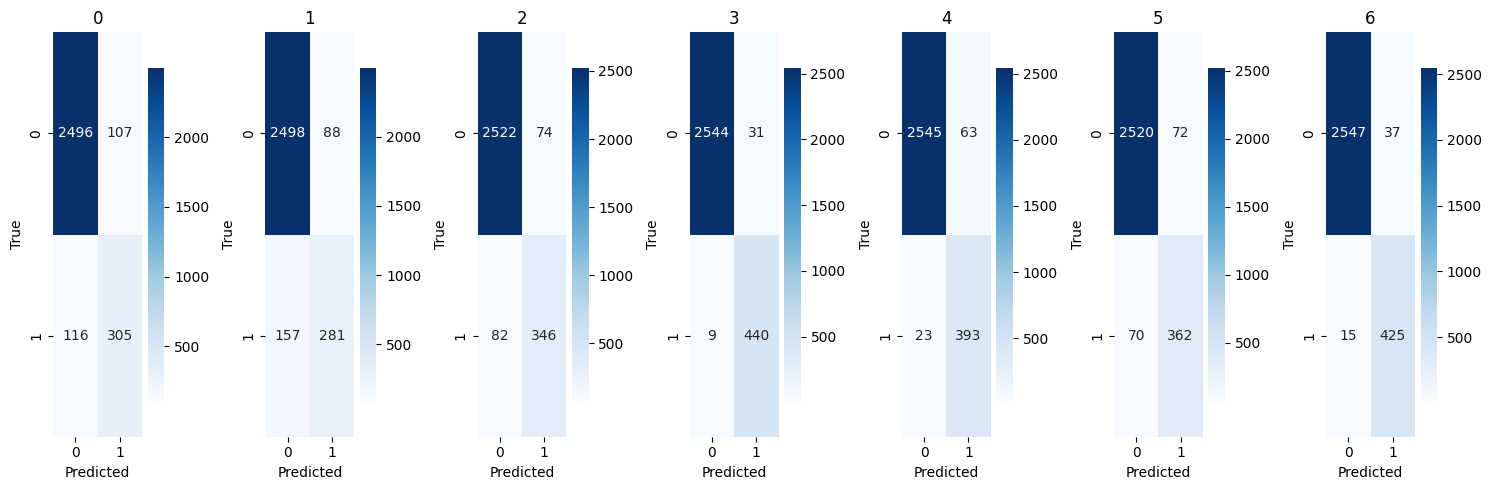

In [86]:
mcm = multilabel_confusion_matrix(y_test, y_pred)


fig, ax = plt.subplots(nrows=1, ncols=mcm.shape[0], figsize=(15, 5))
labels_fore = np.unique(y_target)

for axes, cm, label in zip(ax.flatten(), mcm,labels_fore ):
    sns.heatmap(cm, annot=True, fmt='d', ax=axes, cmap='Blues')
    axes.set_xlabel('Predicted')
    axes.set_ylabel('True')
    axes.set_title(label)

plt.tight_layout()
plt.savefig(base_path + 'confusion_matrix_forest.png')
plt.show()

Mejores hiperparámetros: {'alpha': 0.04225585641493443, 'colsample_bytree': 0.9994673204837426, 'lambda': 0.1010985106998714, 'learning_rate': 0.12199144745225113, 'max_depth': 8.0, 'n_estimators': 654.0, 'subsample': 0.6884234738887477}